In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 📊 Chargement des données
print("📊 Chargement des données...")
file_path = "C:/Users/Massi/Desktop/MSPR BLOC 03/les_jointeurs/datasets/jointeur_elections_population/Dataset_Finale_MSPR_2025.csv"
data = pd.read_csv(file_path, sep=';')
print(f"Dataset complet: {data.shape[0]} lignes")

📊 Chargement des données...
Dataset complet: 69060 lignes


In [3]:

# 🗺️ Filtrage sur la région Bretagne
bretagne_depts = ['22', '29', '35', '56']
data['code_dept'] = data['commune_id'].astype(str).str[:2]
data_region = data[data['code_dept'].isin(bretagne_depts)].copy()

print(f"📍 Région sélectionnée : Bretagne ({', '.join(bretagne_depts)})")
print(f"✅ Nombre de communes : {data_region.shape[0]}")


📍 Région sélectionnée : Bretagne (22, 29, 35, 56)
✅ Nombre de communes : 2412


In [4]:

# 🎯 Vérification des classes
print("\nClasses d'orientation politique :")
print(data_region['orientation_politique'].value_counts().sort_index())

# 🔧 Nettoyage des données
data_region = data_region.dropna(subset=['orientation_politique'])

# 🏷️ Encodage des labels pour XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_region['orientation_politique'])
print(f"\n🏷️ Classes encodées : {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")



Classes d'orientation politique :
orientation_politique
0.0     176
2.0    1733
3.0     121
4.0     382
Name: count, dtype: int64

🏷️ Classes encodées : {0.0: 0, 2.0: 1, 3.0: 2, 4.0: 3}


In [40]:

# 📋 Sélection des variables (features)
features_selected = [
    'nb_inscrits',
    'nb_abstentions',
    'pct_population_sans_activite',
    'pct_population_etrangere',
    'taux_chomage_pct',
    'nb_population_active',
    'Population_Totale',
    'nb_crimes'
]
X = data_region[features_selected].copy()
y = y_encoded

# 🔄 Remplir les valeurs manquantes avec la médiane
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())

# 📦 Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 📏 Standardisation (optionnelle pour XGBoost mais peut améliorer les performances)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [41]:

# 🚀 Entraînement XGBoost - CORRECTION: Forcer l'utilisation du CPU
print("\n🚀 Entraînement du modèle XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1,
    tree_method='hist',  # CORRECTION: Utiliser 'hist' au lieu de 'gpu_hist'
    device='cpu'         # CORRECTION: Forcer l'utilisation du CPU
)

# Entraînement avec données d'évaluation pour suivre les performances
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=eval_set,
    verbose=False
)

# 🎯 Prédictions et évaluation
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🏆 Accuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")

# Convertir les prédictions en labels originaux pour le rapport
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\n📊 Rapport de classification :")
print(classification_report(y_test_labels, y_pred_labels))


🚀 Entraînement du modèle XGBoost...

🏆 Accuracy : 0.7205 (72.05%)

📊 Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.41      0.20      0.27        35
         2.0       0.76      0.92      0.84       347
         3.0       0.20      0.04      0.07        24
         4.0       0.48      0.27      0.35        77

    accuracy                           0.72       483
   macro avg       0.46      0.36      0.38       483
weighted avg       0.67      0.72      0.68       483



In [8]:

# 📈 COURBES D'APPRENTISSAGE - CORRECTION: Paramètres adaptés
print("\n📈 Calcul des courbes d'apprentissage...")
try:
    train_sizes, train_scores, val_scores = learning_curve(
        xgb.XGBClassifier(
            n_estimators=100, 
            random_state=42, 
            eval_metric='mlogloss',
            tree_method='hist',    # CORRECTION: Utiliser 'hist'
            device='cpu'           # CORRECTION: Forcer CPU
        ),
        X_train_scaled, y_train,
        cv=3,  # CORRECTION: Réduire le CV de 5 à 3 pour éviter les erreurs
        train_sizes=np.linspace(0.1, 1.0, 8),  # CORRECTION: Réduire le nombre de points
        n_jobs=1,  # CORRECTION: Utiliser 1 job pour éviter les conflits
        random_state=42,
        scoring='accuracy'
    )
    
    # Calcul des moyennes et écarts-types
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    learning_curves_success = True
except Exception as e:
    print(f"⚠️ Erreur dans le calcul des courbes d'apprentissage: {e}")
    learning_curves_success = False

plt.figure(figsize=(15, 5))


📈 Calcul des courbes d'apprentissage...


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

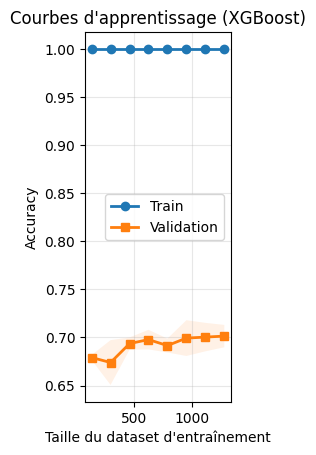

In [9]:

# Courbe d'apprentissage
if learning_curves_success:
    plt.subplot(1, 3, 1)
    plt.plot(train_sizes, train_mean, label='Train', linewidth=2, marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Validation', linewidth=2, marker='s')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Taille du dataset d\'entraînement')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Courbes d\'apprentissage (XGBoost)')
    plt.grid(True, alpha=0.3)
else:
    plt.subplot(1, 3, 1)
    plt.text(0.5, 0.5, 'Courbes d\'apprentissage\nnon disponibles', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Courbes d\'apprentissage (XGBoost)')


📊 Calcul de la courbe de validation...


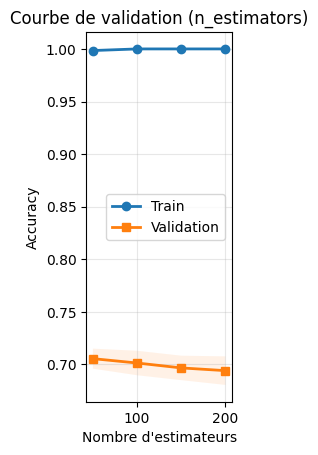

In [10]:

# 📊 COURBE DE VALIDATION - CORRECTION: Paramètres adaptés
print("📊 Calcul de la courbe de validation...")
try:
    n_estimators_range = range(50, 201, 50)  # CORRECTION: Réduire la plage
    train_scores_val, val_scores_val = validation_curve(
        xgb.XGBClassifier(
            random_state=42, 
            eval_metric='mlogloss',
            tree_method='hist',    # CORRECTION: Utiliser 'hist'
            device='cpu'           # CORRECTION: Forcer CPU
        ),
        X_train_scaled, y_train,
        param_name='n_estimators',
        param_range=n_estimators_range,
        cv=3,  # CORRECTION: Réduire le CV
        n_jobs=1,  # CORRECTION: Utiliser 1 job
        scoring='accuracy'
    )
    
    train_mean_val = np.mean(train_scores_val, axis=1)
    train_std_val = np.std(train_scores_val, axis=1)
    val_mean_val = np.mean(val_scores_val, axis=1)
    val_std_val = np.std(val_scores_val, axis=1)
    
    validation_curves_success = True
except Exception as e:
    print(f"⚠️ Erreur dans le calcul de la courbe de validation: {e}")
    validation_curves_success = False

if validation_curves_success:
    plt.subplot(1, 3, 2)
    plt.plot(n_estimators_range, train_mean_val, label='Train', linewidth=2, marker='o')
    plt.fill_between(n_estimators_range, train_mean_val - train_std_val, 
                     train_mean_val + train_std_val, alpha=0.1)
    plt.plot(n_estimators_range, val_mean_val, label='Validation', linewidth=2, marker='s')
    plt.fill_between(n_estimators_range, val_mean_val - val_std_val, 
                     val_mean_val + val_std_val, alpha=0.1)
    plt.xlabel('Nombre d\'estimateurs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Courbe de validation (n_estimators)')
    plt.grid(True, alpha=0.3)
else:
    plt.subplot(1, 3, 2)
    plt.text(0.5, 0.5, 'Courbe de validation\nnon disponible', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Courbe de validation (n_estimators)')


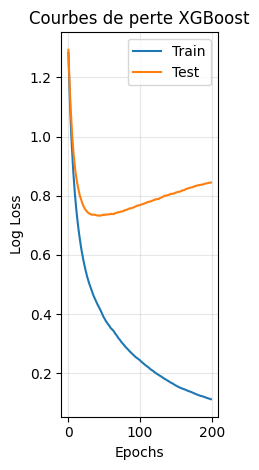

In [11]:

# 📈 Courbe de perte d'entraînement XGBoost
plt.subplot(1, 3, 3)
try:
    results = xgb_model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title('Courbes de perte XGBoost')
    plt.legend()
    plt.grid(True, alpha=0.3)
except Exception as e:
    plt.text(0.5, 0.5, f'Courbes de perte\nnon disponibles\n{str(e)[:50]}...', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Courbes de perte XGBoost')

plt.tight_layout()
plt.show()


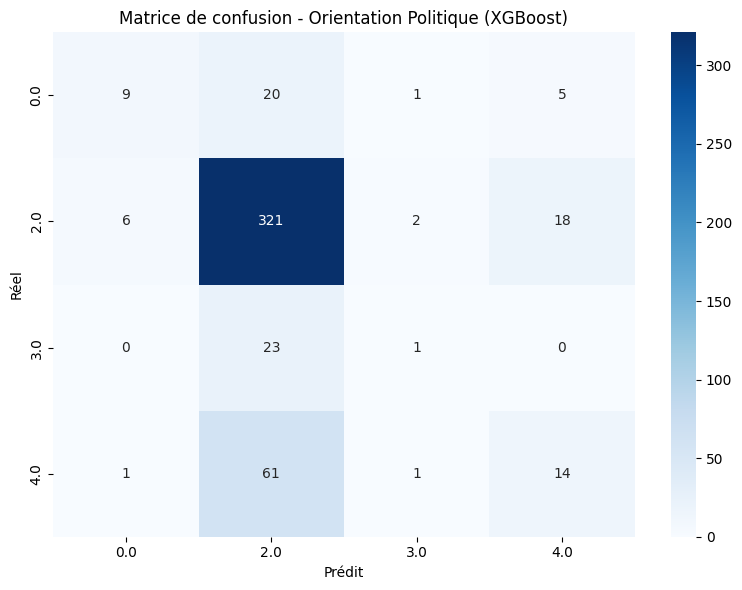

In [12]:

# 🔲 Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion - Orientation Politique (XGBoost)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


🔍 Importance des features (XGBoost) :
nb_inscrits                    : 0.1440
Population_Totale              : 0.1183
taux_chomage_pct               : 0.1182
nb_population_active           : 0.1125
pct_population_etrangere       : 0.1039
nb_abstentions                 : 0.1038
pct_population_senior          : 0.1018
nb_crimes                      : 0.1003
pct_population_sans_activite   : 0.0972


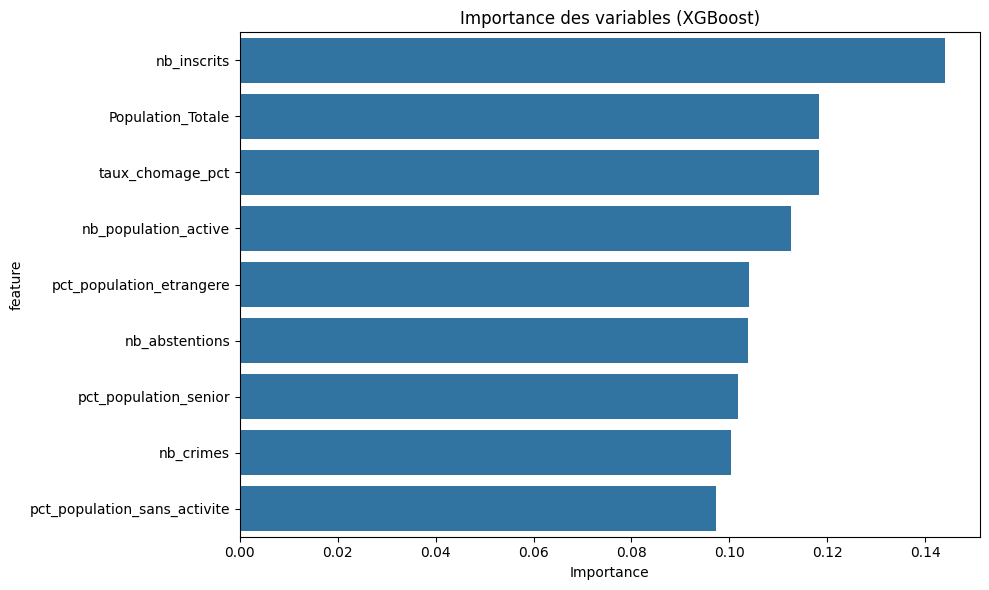

In [13]:

# 🔍 Importance des features XGBoost
feature_importance = pd.DataFrame({
    'feature': features_selected,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n🔍 Importance des features (XGBoost) :")
for i, row in feature_importance.iterrows():
    print(f"{row['feature']:<30} : {row['importance']:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title("Importance des variables (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

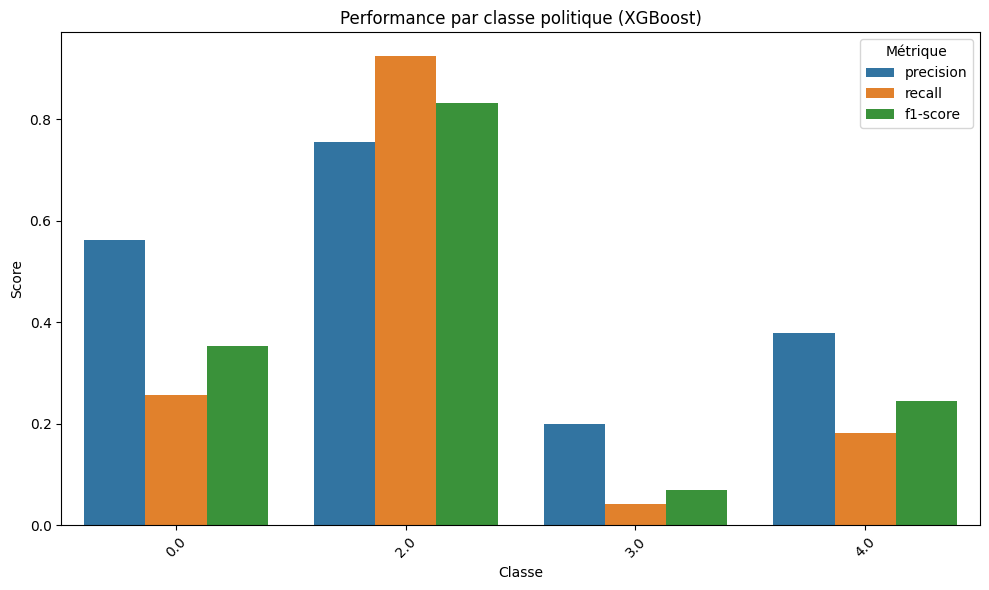

In [14]:

# 📊 Performance par classe
plt.figure(figsize=(10, 6))
report_dict = classification_report(y_test_labels, y_pred_labels, output_dict=True)
classes = [k for k in report_dict.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
metrics = ['precision', 'recall', 'f1-score']

performance_data = []
for classe in classes:
    for metric in metrics:
        performance_data.append({
            'Classe': classe,
            'Métrique': metric,
            'Score': report_dict[classe][metric]
        })

performance_df = pd.DataFrame(performance_data)
sns.barplot(data=performance_df, x='Classe', y='Score', hue='Métrique')
plt.title('Performance par classe politique (XGBoost)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:

# 🔮 Fonction de prédiction personnalisée
def predire_orientation(nb_inscrits, nb_abstentions, pct_population_senior,
                       pct_population_sans_activite, 
                       pct_population_etrangere, taux_chomage_pct,
                       nb_population_active, population_totale, nb_crimes):
    """
    Prédire l'orientation politique d'une commune
    """
    new_data = np.array([[nb_inscrits, nb_abstentions, pct_population_senior,
                        pct_population_sans_activite, 
                         pct_population_etrangere, taux_chomage_pct,
                         nb_population_active, population_totale, nb_crimes]])
    new_data_scaled = scaler.transform(new_data)
    prediction_encoded = xgb_model.predict(new_data_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]
    proba = xgb_model.predict_proba(new_data_scaled)[0]
    
    # Créer un dictionnaire avec les probabilités par classe
    proba_dict = {label_encoder.classes_[i]: proba[i] for i in range(len(proba))}
    
    return prediction, proba_dict



# 📝 Résumé
print("\n🎉 RÉSUMÉ FINAL :")
print(f"📍 Région analysée : Bretagne ({', '.join(bretagne_depts)})")
print(f"📊 Communes utilisées : {len(data_region)}")
print(f"🎯 Accuracy obtenue : {accuracy*100:.2f}%")
print(f"🚀 Modèle utilisé : XGBoost (CPU)")
print(f"🌲 Nombre de features : {len(features_selected)}")
print(f"📈 Graphiques générés : Apprentissage + Validation + Perte")
print(f"💾 Modèle prêt pour les prédictions personnalisées")


🎉 RÉSUMÉ FINAL :
📍 Région analysée : Bretagne (22, 29, 35, 56)
📊 Communes utilisées : 2412
🎯 Accuracy obtenue : 71.43%
🚀 Modèle utilisé : XGBoost (CPU)
🌲 Nombre de features : 9
📈 Graphiques générés : Apprentissage + Validation + Perte
💾 Modèle prêt pour les prédictions personnalisées
